# Bayesian VAE 

In [1]:
from pathlib import Path

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

import pmldiku
from pmldiku import data, vae, model_utils

%load_ext autoreload
%autoreload 1
%aimport pmldiku.data, pmldiku.vae, pmldiku.model_utils

In [2]:
torch.manual_seed(1)

CUDA = True
BATCH_SIZE = 128
LOGPX_LOSS = "mse"
DEVICE_NAME = "cuda" if CUDA else "cpu"

DEVICE = torch.device(DEVICE_NAME)
kwargs = {'num_workers': 4, 'pin_memory': DEVICE} 

In [3]:
# Val equals test here :)
train_loader = data.load_mnist(train=True).setup_data_loader(batch_size=BATCH_SIZE, **kwargs)
val_loader = data.load_mnist(train=False).setup_data_loader(batch_size=BATCH_SIZE, **kwargs)  

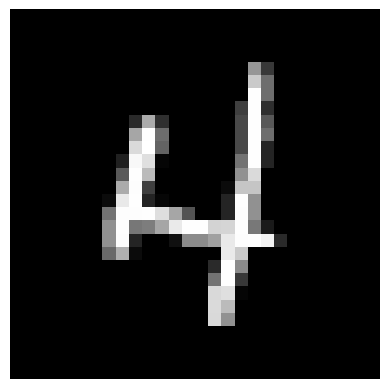

In [4]:
X, y = next(iter(train_loader))
img = X[0].squeeze().numpy()
model_utils.plot_img(img)

In [5]:
bayes_vae = vae.BayesVAE(hidden_dim=5)
bayes_vae(X)

(tensor([[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<SigmoidBackward0>),
 tensor([[-2.4913e-02,  2.4521e-02, -2.2980e-02, -1.8327e-02,  2.6264e-02],
         [-1.8427e-02,  5.0007e-02,  6.1620e-03, -1.2502e-02,  6.2049e-02],
         [-4.2879e-02,  5.5429e-02, -1.4402e-04, -5.0580e-02,  3.2807e-02],
         [-1.1437e-02,  3.2211e-02, -8.4612e-03, -2.1247e-02,  4.2941e-02],
         [-2.2322e-02,  3.1962e-02, -9.7556e-04, -8.6904e-03,  3.0355e-02],
         [-1.5270e-02,  5.1503e-02, -2.3576e-02, -1.8622e-02,  6.4494e-02],
         [-4.5391e-02,  3.7894e-02, -1.0632e-02,  7.8243e-03,  5.8622e-02],
         [-1.5656e-02,  6.8181e-03,  1.3988e-02, -2.1729e-02,  1.3886e-02],
         [-3.4052e-02,  4.7316e-02,  6.9208e-04, -4.0347e-02,  2.8

# Train model

In [6]:
# Model
bayes_vae = vae.BayesVAE(hidden_dim=2)
model = vae.LitBayesVAE(vae=bayes_vae, logpx_loss=LOGPX_LOSS)

# Callbacks
loss_callback = vae.VAELossCallback()
reconstruct_cb = vae.VAEImageReconstructionCallback()
cb_checkpoint = ModelCheckpoint(
    dirpath=pmldiku.FP_MODELS,
    filename='mnist-BayesVAE-BCE-{epoch:02d}-{val_loss:.2f}'
)
cb_earlystopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks = [loss_callback, reconstruct_cb, cb_checkpoint, cb_earlystopping]

# Trainer
trainer = pl.Trainer(max_epochs=-1, devices=1, accelerator=DEVICE_NAME, callbacks=callbacks)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/scratch/fjr906/miniconda3/envs/pml/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /scratch/fjr906/projects/pml/pmldiku-exam-paper/code/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type     | Params
----------------------------------
0 | vae  | BayesVAE | 985 K 
----------------------------------
985 K     Trainable params
0         Non-trainable params
985 K     Total params
3.943     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False,  True,  True,
        False,  True, False, False, False,  True, False, False, False,
         True, False, False,  True, False, False, False,  True, False,
         True, False,  True,  True, False,  True,  True, False, False,
         True, False,  True, False,  True]),
 array([45939.23046875, 18214.46289062, 16704.99804688, 16493.23828125,
        16365.34375   , 16275.37402344, 16084.41113281, 15905.59179688,
        15829.6484375 , 15715.14355469, 15593.95214844, 15532.125     ,
        15463.58886719, 15368.88769531, 15371.75195312, 15337.83398438,
        15256.63867188, 15271.87695312, 15275.91992188, 15193.09472656,
        15242.57421875, 15212.55664062, 15168.16992188, 15159.78710938,
        15182.64941406, 15162.05078125, 15104.81640625, 15079.12304688,
        15086.015625  , 15067.01757812, 15062.84667969, 15083.91210938,
        15077.58886719, 

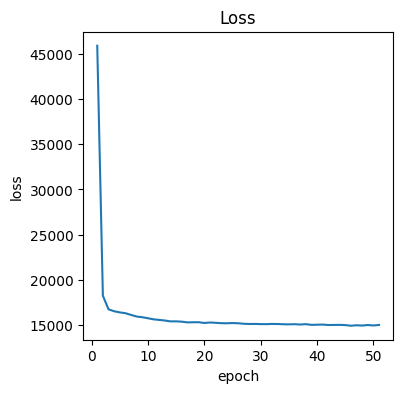

In [10]:
losses = np.array(loss_callback.val_loss)
model_utils.plot_loss(losses)
np.diff(losses) > 0, losses

# Reconstruction of model for each epoch of training

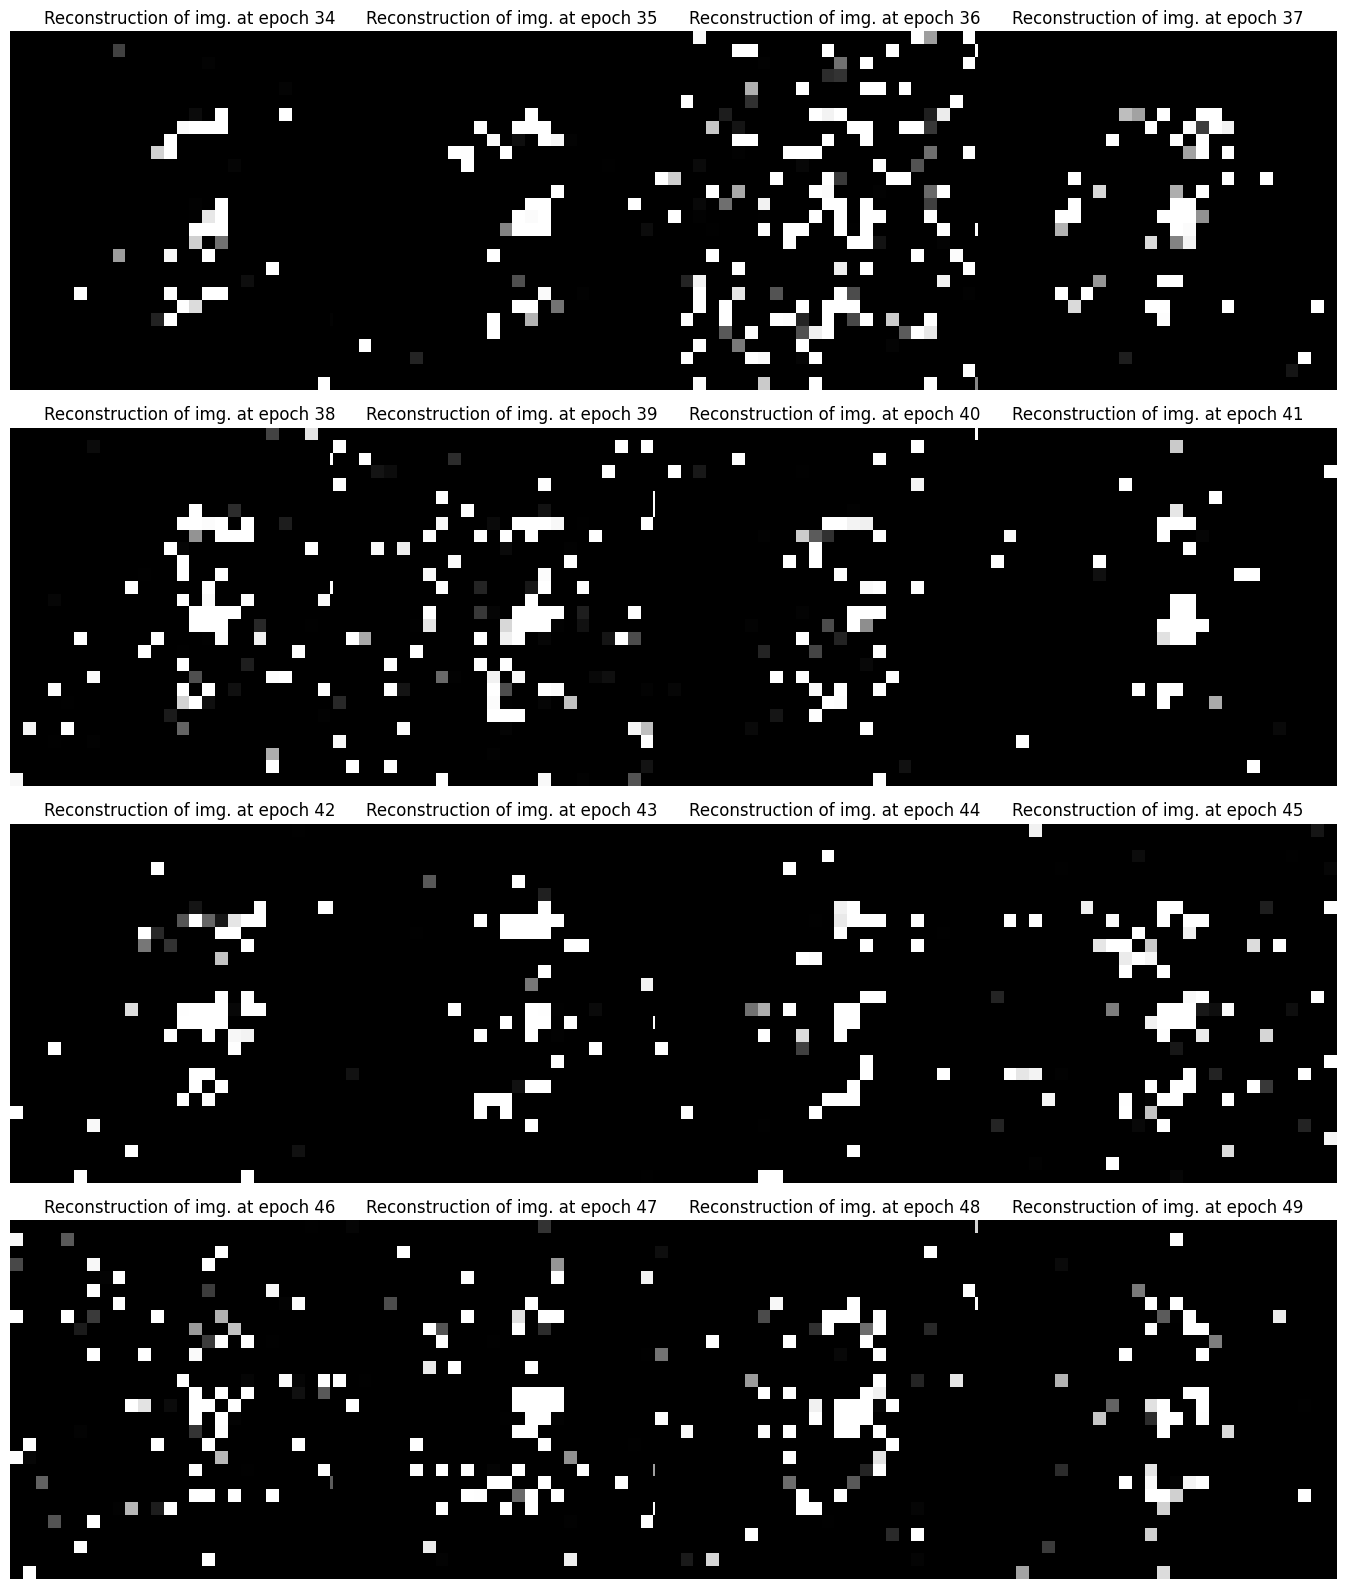

In [9]:
# Take first image of each batch of reconstructed images
images = reconstruct_cb.samples[-16:, 0, :, :].cpu().numpy()
start = cb_earlystopping.stopped_epoch - 16
model_utils.plot_image_reconstruction(images, num_cols=4, slim=20, start=start)

# Expected value in latent space for each number

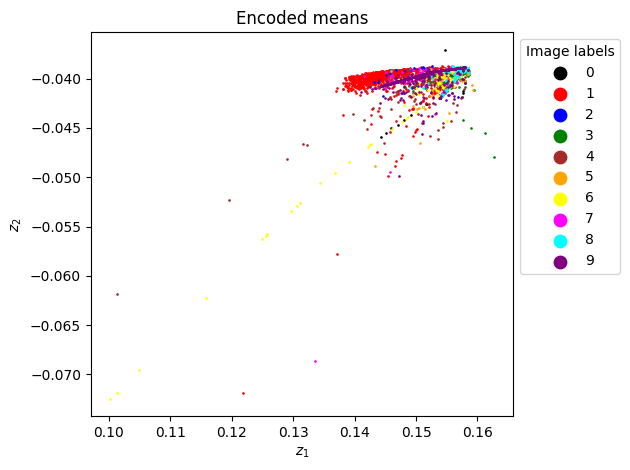

In [11]:
means_plot, labels = vae.encode_means(model.vae, val_loader)
plot_args = dict(title="Encoded means", xlabel=r"$z_1$", ylabel=r"$z_2$")
model_utils.plot_encoded(means_plot, labels, **plot_args)

# Reconstruction of equally spaced gaussian noise

In [17]:
gauss_vals = model_utils.construct_gauss_grid(M=12)
decoded_imgs = model.vae.decode(gauss_vals).detach().numpy()
model_utils.plot_gauss_grid_imgs(decoded_imgs)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (144x2 and 10x400)

# Inspect output

In [12]:
model.vae.logvar_theta.exp().sqrt()

tensor([0.7265, 0.7667, 0.7192,  ..., 1.0112, 0.9910, 1.0033],
       grad_fn=<SqrtBackward0>)

In [13]:
torch.exp(0.5 * model.vae.logvar_theta)

tensor([0.7265, 0.7667, 0.7192,  ..., 1.0112, 0.9910, 1.0033],
       grad_fn=<ExpBackward0>)

In [ ]:
import seaborn as sns
means = model.vae.mu_theta.detach().numpy()
sns.histplot(means)